In [1]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


In [2]:
df = pd.read_csv("/kaggle/input/titanic/train.csv")
test_df = pd.read_csv("/kaggle/input/titanic/test.csv")
df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


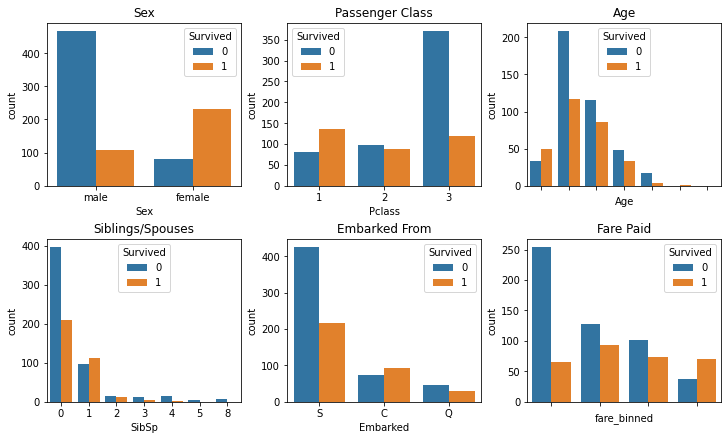

In [3]:
# Feature Analysis

fig, axs = plt.subplots(2, 3, constrained_layout=True, figsize=(10, 6))

sns.countplot(data=df, ax=axs[0,0], x="Sex", hue="Survived")
axs[0,0].set_title("Sex")

sns.countplot(data=df, ax=axs[0,1], x="Pclass", hue="Survived")
axs[0,1].set_title("Passenger Class")

bins = [i for i in range(0,110, 15)]
df['binned'] = pd.cut(df['Age'], bins)
sns.countplot(data=df, ax=axs[0,2], x="binned", hue="Survived")
axs[0,2].set_title("Age")
axs[0,2].set_xlabel("Age")
axs[0,2].set_xticklabels([])

sns.countplot(data=df, ax=axs[1,0], x="SibSp", hue="Survived")
axs[1,0].set_title("Siblings/Spouses")

sns.countplot(data=df, ax=axs[1,1], x="Embarked", hue="Survived")
axs[1,1].set_title("Embarked From")

bins = [0, 10, 25, 50, 100]
df['fare_binned'] = pd.cut(df['Fare'], bins)
sns.countplot(data=df, ax=axs[1,2], x="fare_binned", hue="Survived")
axs[1,2].set_title("Fare Paid")
axs[1,2].set_xticklabels([])

plt.show()

In [4]:
groupbydf = df[["binned", "Survived"]].groupby("binned", dropna=False).agg(["count", "sum"])
groupbydf.columns = groupbydf.columns.droplevel()
groupbydf = groupbydf.reset_index()
groupbydf["percent"] = groupbydf["sum"]/groupbydf["count"]
groupbydf

,binned,count,sum,percent
0,"(0, 15]",83,49,0.590361
1,"(15, 30]",326,117,0.358896
2,"(30, 45]",202,86,0.425743
3,"(45, 60]",81,33,0.407407
4,"(60, 75]",21,4,0.190476
5,"(75, 90]",1,1,1.000000
6,"(90, 105]",0,0,NaN


In [5]:
def get_title(x):
    return x['Name'].split(',')[1].split(' ')[1]

df['Title'] = df.apply(get_title, axis=1)
test_df['Title'] = test_df.apply(get_title, axis=1)

print(df['Title'].value_counts())

Mr.          517
Miss.        182
Mrs.         125
Master.       40
Dr.            7
Rev.           6
Mlle.          2
Major.         2
Col.           2
the            1
Capt.          1
Ms.            1
Sir.           1
Lady.          1
Mme.           1
Don.           1
Jonkheer.      1
Name: Title, dtype: int64


In [6]:
# Feature Selection

X = df[["Pclass", "Sex", "Age", "SibSp", "Fare", "Embarked", "Title"]]
y = df["Survived"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [7]:
# Scikit Learn Pipeline

numerical_features = ['Age', 'Fare', 'SibSp']
numerical_transformer = Pipeline(
    steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ]
)

categorical_features = ['Sex', 'Pclass', 'Embarked', 'Title']
categorical_transformer = Pipeline(
    steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ]
)

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

classifier = LogisticRegression(random_state=0)

pipe = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', classifier)])
pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Age', 'Fare', 'SibSp']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   On

In [8]:
# Scoring the Validation Set

y_pred = pipe.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.86      0.86      0.86       175
           1       0.80      0.79      0.79       120

    accuracy                           0.83       295
   macro avg       0.83      0.83      0.83       295
weighted avg       0.83      0.83      0.83       295



In [9]:
# Preparing Predictions for Submission

test = test_df[["Pclass", "Sex", "Age", "SibSp", "Fare", "Embarked", 'Title']]

y_test_pred = pipe.predict(test)

output = pd.DataFrame()
output["PassengerId"] = test_df["PassengerId"]
output["Survived"] = y_test_pred
output.to_csv("/kaggle/working/submission_v1.csv", index=False)